In [1]:
import math
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from pathlib import Path
import warnings
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def find_center_wavel(wavel, trans, thres):
    w, tr = [], []
    for i in range(len(trans)-1):
        if trans[i] > thres and trans[i+1] < thres:
            w.append(wavel[i])
            w.append(wavel[i+1])
            tr.append(trans[i])
            tr.append(trans[i+1])
        if trans[i] < thres and trans[i+1] > thres:
            w.append(wavel[i])
            w.append(wavel[i+1])
            tr.append(trans[i])
            tr.append(trans[i+1])
    
    w1 = lin_interp(thres, tr[0], w[0], tr[1], w[1])
    w2 = lin_interp(thres, tr[2], w[2], tr[3], w[3])

    return (w1 + w2) / 2

def lin_interp(x, x0, y0, x1, y1):
    y = y0 + ((y1 - y0) / (x1 - x0)) * (x - x0)
    return y

In [ ]:
p_current = Path().resolve().parent
data_path = p_current / 'results' / 'ring_data' / 'pdk_crr_test_cells_thermal_xtalk_100C' / 'reticle55'

volts = np.arange(0, 1.6, 0.1)
spacings = [200, 400, 600, 800, 1000, 1200]
# spacings = [1200]
thres = -20
center_wavels_all = {}
elec_pwr = {}

# data_dir_gen = sorted(data_path.glob(f'*um/*.json'))
for s in spacings:
    dir = data_path / f'{s}um' / 'pdk_crr_test_cells.json'
    df = pd.read_json(dir)
    ret = int(df['reticle'][0])

    wavel = df['wavelength'][0]
    trans = df['transmission_ch1'][0]
    currs = np.multiply(1000, df['smu_current'][0])

    center_wavels = []
    for tr in trans:
        center_wavels.append(find_center_wavel(wavel, tr, thres))
    center_wavels_all[s] = center_wavels

    elec_pwr[s] = np.multiply(volts, currs)

shift = lambda x_arr: np.multiply(1000, [x - x_arr[0] for x in x_arr])
wavel_shift_pm = {s:shift(cw) for s, cw in center_wavels_all.items()}
print(wavel_shift_pm)

# min_wavel = []
# for tr in trans:
#     min_wavel.append(wavel[tr.index(min(tr))])

In [ ]:
# plot spectra for all voltages
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, v in enumerate(volts):
    ax.plot(wavel, trans[i], '-', label=f'{v} V')
# ax.plot(wavel, trans[0], '--', label=f'{0} V')
# ax.plot(wavel, trans[10], '--', label=f'{0.1} V')
# ax.plot(wavel, trans[15], '--', label=f'{1.5} V')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Transmission (dB)')
ax.set_title('Agressor 6, distance: 1200 um')
# ax.set_xlim([1305.2, 1307.2])
# ax.legend()

In [ ]:
# plot wavelength shift vs voltage for all spacings
wavel_shift_pm[200][5] = 4.5
wavel_shift_pm[600][10] = 4.98
wavel_shift_pm[800][14] = 8.1
wavel_shift_pm[1000][1] = -0.02
wavel_shift_pm[1000][13] = 5.75

print(wavel_shift_pm[800])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for (dist1, ep), (dist2, shift) in zip(elec_pwr.items(), wavel_shift_pm.items()):
    ax.plot(ep, shift, 'o--', label=f'{dist1} um')
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Wavelength shift (pm)')
ax.set_title('Wavelength shift vs electrical power at 30 C')
ax.legend()
ax.set_ylim([-2, 30])

In [ ]:
# plot shift vs spacing at 1.5 V
shift_1p5 = []
for sh in wavel_shift_pm.values():
    shift_1p5.append(sh[-1])

coefs = poly.polyfit(spacings, shift_1p5, 5)
ffit = poly.Polynomial(coefs) 
new_dist = np.arange(100, 1401, 1)

print(shift_1p5)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(spacings, shift_1p5, 'o--', color='k')
ax.plot(new_dist, ffit(new_dist), color='k')
ax.plot(150, ffit(150), marker='*', markersize=10, color='r', label=f'Fitted shift at 150 um: {ffit(150):.1f} pm')
ax.set_xlabel('Distance (um)')
ax.set_ylabel('Wavelength shift (pm)')
ax.set_title('Wavelength shift vs distance at 1.5 V')
ax.set_xlim([0, 1500])
ax.legend()

In [ ]:
# plot IV curve for all three temperatures
p_current = Path().resolve().parent
data_fldr = p_current / 'results' / 'ring_data'

volts = np.arange(0, 2.1, 0.1)
temps = [30, 70, 100]
currs = {}

# data_dir_gen = sorted(data_path.glob(f'*um/*.json'))
for t in temps:
    dir = data_fldr / f'pdk_mrm56_highspeed_test_cells_thermal_xtalk_{t}C' / 'reticle27' / '200um' / 'pdk_mrm56_highspeed_test_cells.json'
    df = pd.read_json(dir)
    ret = int(df['reticle'][0])
    currs[t] = np.multiply(1000, df['smu_current'][0])

# plot the IV curve
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for t in temps:
    ax.plot(volts, currs[t], label=f'{t} C')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (mA)')
ax.set_title('MRM I-V curve: reticle 27')
ax.legend()


In [ ]:
###########################################################################################

In [3]:
# Thermal crosstalk coefficient extraction for aggressor
p_current = Path().resolve().parent
data_path = p_current / 'Dione_data' / 'pdk_mrm56_highspeed_test_cells_thermal_xtalk_30C' / 'reticle27'

volts = np.arange(0, 2.1, 0.1)
spacings = [200]
center_wavels_all = {}
elec_pwr = {}
thres = -29

# data_dir_gen = sorted(data_path.glob(f'*um/*.json'))
for s in spacings:
    dir = data_path / f'{s}um' / 'pdk_mrm56_highspeed_test_cells.json'
    df = pd.read_json(dir)
    ret = int(df['reticle'][0])

    wavel = df['wavelength'][0]
    trans = df['transmission_ch1'][0]
    currs = np.multiply(1000, df['smu_current'][0])

    center_wavels = []
    for tr in trans:
        center_wavels.append(find_center_wavel(wavel, tr, thres))
    center_wavels_all[s] = center_wavels

    elec_pwr[s] = np.multiply(volts, currs)

shift = lambda x_arr: np.multiply(1000, [x - x_arr[0] for x in x_arr])
wavel_shift_pm = {s:shift(cw) for s, cw in center_wavels_all.items()}
print(wavel_shift_pm)
print(len(elec_pwr[s]))
def lin_func(x, a):
    return a * x

{200: array([ 0.        , -0.78649093, -0.30803141,  0.32793866,  1.11834245,
        1.64800606,  4.18077285,  4.1026355 ,  3.97870793,  6.34632146,
        8.29311675,  9.27595867, 10.31068723, 11.11641448, 13.67968264,
       15.15929381, 14.77781911, 17.64874807, 19.12887518, 18.7667859 ,
       20.46086571])}
21


[0.09047205 0.45389899]


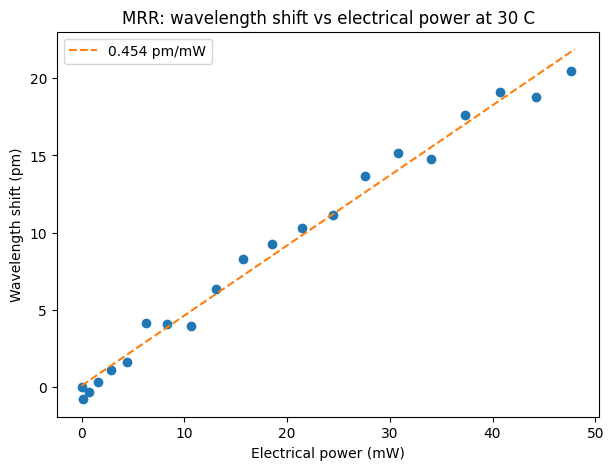

In [4]:
# plot wavelength shift
# params, cov = curve_fit(lin_func, elec_pwr[spacings[0]], wavel_shift_pm[spacings[0]])
coefs = poly.polyfit(elec_pwr[spacings[0]], wavel_shift_pm[spacings[0]], 1)
print(coefs)
ffit = poly.Polynomial(coefs)
x_data = np.linspace(0, math.ceil(elec_pwr[spacings[0]][-1]), 100)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for (dist1, ep), (dist2, shift) in zip(elec_pwr.items(), wavel_shift_pm.items()):
    ax.plot(ep, shift, 'o')
# ax.plot(x_data, lin_func(x_data, *params), '--', label=f'{params[0]:.3f} pm/mW')
ax.plot(x_data, ffit(x_data), '--', label=f'{coefs[1]:.3f} pm/mW')
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Wavelength shift (pm)')
ax.set_title('MRR: wavelength shift vs electrical power at 30 C')
ax.legend()

In [ ]:
###########################################################################################

In [3]:
# Thermal crosstalk coefficient extraction for self
p_current = Path().resolve().parent
data_path = p_current / 'Dione_data' / 'pdk_mrm56_highspeed_test_cells_thermal_xtalk_100C' / 'reticle27'

volts = np.arange(0, 2.1, 0.1)
spacings = [0]
thres = -20
center_wavels_all = {}
elec_pwr = []
wavel = []
trans = []

# data_dir_gen = sorted(data_path.glob(f'*um/*.json'))
dir = data_path / '0um' / 'pdk_mrm56_highspeed_test_cells.json'
df = pd.read_json(dir)
ret = int(df['reticle'][0])
wavel = df['wavelength'][0]
for i, v in enumerate(volts):
        trans.append(df['transmission_ch1'][0][i])
currs = np.multiply(1000, df['smu_current'][0])
elec_pwr = np.multiply(volts, currs)

def lin_func(x, a):
    return a * x

def find_index(target_wavel) -> list:
    idx = []
    for t in target_wavel:
        for w in wavel:
            if abs(t - w) < 0.0001:
                idx.append(wavel.index(w))
    return idx


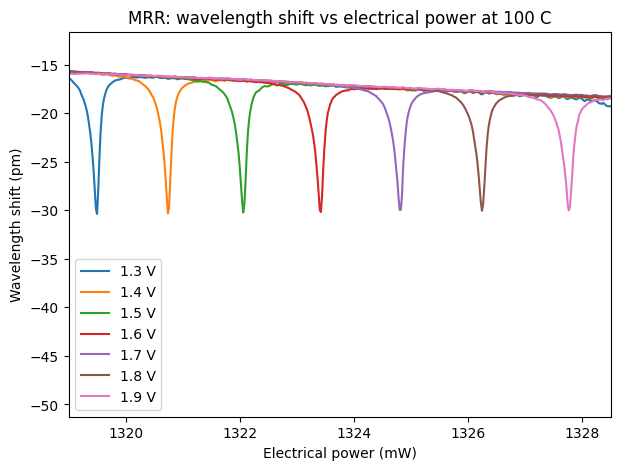

In [6]:
# plot wavelength shift
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i in [13,14,15,16,17,18,19]:  #[0,1,2,3,4,5,6,7,8,9,10,11,12]:  #[13,14,15,16,17,18,19]:  #[8,9,10,11,12]:  #[13, 14,15]:  #
    ax.plot(wavel, trans[i], '-', label=f'{volts[i]:.1f} V')
for pw in center_wavels_0to12:
    ax.axvline(pw, linestyle='--')
# for pw in center_wavels_13to19:
#     ax.axvline(pw, linestyle='--')
# for pw in center_wavels_13to15:
#     ax.axvline(pw, linestyle='--')
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Wavelength shift (pm)')
ax.set_title('MRR: wavelength shift vs electrical power at 100 C')
ax.set_xlim([1319, 1328.5])
# ax.set_ylim([-30, -10])
ax.legend()

In [5]:
# find dip center wavelength
thres = -29

idx = find_index([1310, 1319])
center_wavels_0to12 = []
for i, tr in enumerate(trans[:13]):
    center_wavels_0to12.append(find_center_wavel(wavel[idx[0]:idx[1]], tr[idx[0]:idx[1]], thres))

idx = find_index([1319, 1328.5])
center_wavels_13to19 = []
for i, tr in enumerate(trans[13:20]):
    center_wavels_13to19.append(find_center_wavel(wavel[idx[0]:idx[1]], tr[idx[0]:idx[1]], thres))

# thres = -28
# idx = find_index([1317, 1338.5])
# center_wavels_13to15 = []
# for i, tr in enumerate(trans[13:16]):
#     center_wavels_13to15.append(find_center_wavel(wavel[idx[0]:idx[1]], tr[idx[0]:idx[1]], thres))

center_wavels = center_wavels_0to12 + center_wavels_13to19
print(center_wavels)

wavel_shift_nm = [cw - center_wavels[0] for cw in center_wavels]

[1310.2615073360507, 1310.308537368292, 1310.489074049924, 1310.8089291518907, 1311.2416811551716, 1311.7907340007619, 1312.452264040045, 1313.1946816422128, 1314.0750000958315, 1315.009514647642, 1316.0193049635127, 1317.099543515939, 1318.2450461735475, 1319.4911149185955, 1320.745053258906, 1322.060823486474, 1323.4112518502716, 1324.8080989382368, 1326.2408590371451, 1327.7620473317722]


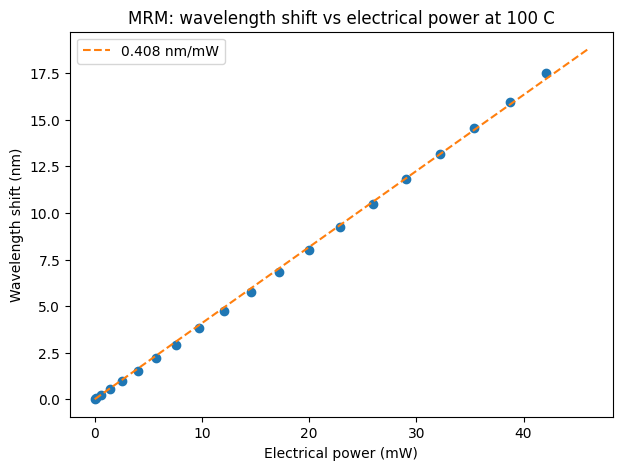

In [7]:
# plot wavelength shift
params, cov = curve_fit(lin_func, elec_pwr[:20], wavel_shift_nm)
x_data = np.linspace(0, math.ceil(elec_pwr[-1]), 100)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(elec_pwr[:20], wavel_shift_nm, 'o')
ax.plot(x_data, lin_func(x_data, *params), '--', label=f'{params[0]:.3f} nm/mW')
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Wavelength shift (nm)')
ax.set_title('MRM: wavelength shift vs electrical power at 100 C')
ax.legend()